# 프로젝트: Spectrogram classification 모델 구현

만약에, 우리가 Waveform 데이터 대신 이 Spectrogram 포맷으로 모든 음성 데이터를 변환한 후 음성인식 모델을 학습시킨다면, 과연 Waveform과 비교했을 때 더 나은 성능을 기대할 수 있을까요?

오늘 실습에서 1차원 Waveform 데이터를 입력받아 Text 라벨을 출력하는 모델을 기본 버전과 Skip-connection 버전으로 나누어 학습시켜 보았습니다. 이번에는 2차원 Spectrogram 데이터를 입력받아 위 모델과 동일한 역할을 수행하는 모델을 아래 제시된 단계와 같이 수행해 보시기 바랍니다. 이번에도 마찬가지로 기본 버전과 Skip-connection 버전으로 나누어 각각 진행해 보시기 바랍니다.  
모델 구조를 제외하고는 실습에서 제시된 것과 거의 동일하게 진행될 것입니다.

## 1. 데이터 처리와 분류

-   라벨 데이터 처리하기
-   `sklearn`의  `train_test_split`함수를 이용하여 train, test 분리

## 2. 학습을 위한 하이퍼파라미터 설정

## 3. 데이터셋 구성

-   `tf.data.Dataset`을 이용
-   from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
-   map과 batch를 이용한 데이터 전처리
-   주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.  
    `tf.data.Dataset`이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.
<br></br>
> 메모리 버퍼 비우기
```python
del speech_data 
del spec_data
```
<br></br>

## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성


-   2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
-   batchnorm, dropout, dense layer 등을 이용
-   12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
-   모델 가중치를 저장하는 checkpoint callback 함수 추가
-   다양한 모델의 실험을 진행해 보시기 바랍니다.

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

-   loss, accuracy를 그래프로 표현

## 6. Test dataset을 이용해서 모델의 성능을 평가

-   저장한 weight 불러오기
-   모델의 예측값과 정답값이 얼마나 일치하는지 확인
***

## 1. 데이터 처리와 분류

In [1]:
# 패키지 가져오기
import numpy as np
import os

# 데이터 불러오기
data_path = os.getenv("HOME") + '/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)
# print('실행완료')

In [3]:
# 2데이터로 변환

# 2c차원 spectrogram 데이터를 처리하는 모델 구성

import librosa
import matplotlib.pyplot as plt

# spectrogram shape을 맞추기위해서 size 변형
def wav2spec(wav, fft_size = 258): 
    D = np.abs(librosa.stft(wav, n_fft = fft_size))
    return D

spec_data = []

for wav in speech_data["wav_vals"] : 
    spec_data.append(wav2spec(wav))
    

spec_data = np.array(spec_data)

# print("실행완료")

In [5]:
# 데이터 처리

# label data 처리

# 구분해야할 label 목록
label_value = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']


#print('LABEL : ', label_value)

# 새로운 딕셔너리 변수 생성
new_label_value = dict()

for i, l in enumerate(label_value) :

    # 데이터 값과 인덱스의 위치 변환, 데이터 값이 입력되면 인덱스 값이 출력
    # (딕셔너리 형태이므로, 데이터 값 = 키 값)
    new_label_value[l] = i
    
label_value = new_label_value

# print("Indexed LABEL : ", new_label_value)

In [6]:
# index 작업을 통해 label data 를 더 쉽게 사용가능

temp = []

for v in speech_data["label_vals"] :
    temp.append(label_value[v[0]])  
    
label_data = np.array(temp)

# label_data  

In [7]:
# 데이터 분리

from sklearn.model_selection import train_test_split

# sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(spec_data, label_data, test_size = 0.1, shuffle = True)

# 채널을 cnn 모델에 추가하기
train_wav = train_wav.reshape([-1, 130, 126, 1])
test_wav = test_wav.reshape([-1, 130, 126, 1])

In [8]:
# 메모리 확보를 위한 필요없는 변수 삭제
del spec_data

In [9]:
# 나눈 데이터 셋 확인

print("train data 개수 : ",train_wav.shape)
print("train label 개수 : ", train_label.shape)
print("test data 개수 : ",  test_wav.shape)
print("test label 개수 : ", test_label.shape)

train data 개수 :  (45558, 130, 126, 1)
train label 개수 :  (45558,)
test data 개수 :  (5062, 130, 126, 1)
test label 개수 :  (5062,)


## 2. 학습을 위한 하이퍼파라미터 설정

In [10]:
# 하이퍼 파마리터 설정

batch_size = 32
max_epochs = 10

# 체크 포인트 경로 설정
checkpoint_dir = os.getenv("HOME") + '/speech_recognition/models/'

# checkpoint_dir

## 3. 데이터셋 구성

In [11]:
# 데이터 구성

def one_hot_label(wav, label) : 
    label = tf.one_hot(label, depth = 12)
    return wav, label

In [12]:
# 모델 구현

import tensorflow as tf

print(train_wav.shape, test_label.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size = batch_size)
print(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size = batch_size)
print(test_dataset)

(45558, 130, 126, 1) (5062,)
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

In [13]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

In [14]:
# 학습 모델 평가

optimizer = tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), optimizer = optimizer, metrics = ["accuracy"])

In [15]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only = True,
                                                 monitor = 'val_loss',
                                                 mode = 'auto',
                                                 save_best_only = True,
                                                 verbose = 1)

In [16]:
# 모델 학습 코드

history_wav = model_wav.fit(train_dataset, epochs = max_epochs,
                    steps_per_epoch = len(train_wav) // batch_size,
                    validation_data = test_dataset,
                    validation_steps = len(test_wav) // batch_size,
                    callbacks = [cp_callback]
                    )

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.7790
Epoch 00001: val_loss improved from inf to 0.37571, saving model to /home/aiffel/speech_recognition/models/
1423/1423 [==============================] - 205s 144ms/step - loss: 0.6682 - accuracy: 0.7790 - val_loss: 0.3757 - val_accuracy: 0.8780
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2314 - accuracy: 0.9265
Epoch 00002: val_loss improved from 0.37571 to 0.28123, saving model to /home/aiffel/speech_recognition/models/
1423/1423 [==============================] - 207s 145ms/step - loss: 0.2314 - accuracy: 0.9265 - val_loss: 0.2812 - val_accuracy: 0.9062
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9482
Epoch 00003: val_loss improved from 0.28123 to 0.24377, saving model to /home/aiffel/speech_recognition/models/
1423/1423 [==============================] - 207s 146ms/step - loss: 0.1589 - accuracy: 0.9482 - val

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

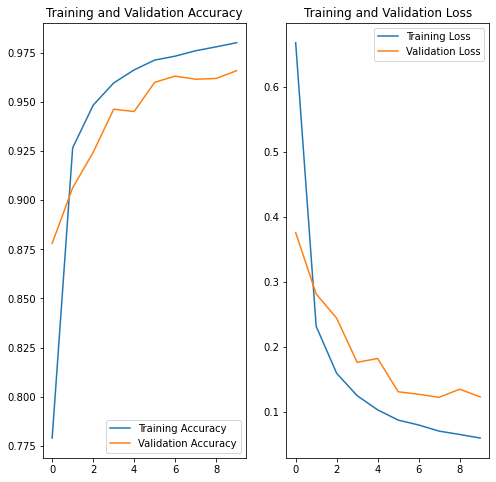

In [17]:
# 학습 모델 평가 성능 시각화

import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss = history_wav.history['loss']
val_loss = history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. Test dataset을 이용해서 모델의 성능을 평가

In [20]:
# checkpoint callback 함수가 저장한 weight 를 다시 불러와 테스트 준비

model_wav.load_weights(checkpoint_dir)

In [21]:
# test data 를 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인

results = model_wav.evaluate(test_dataset)

159/159 [==============================] - 23s 143ms/step - loss: 0.1218 - accuracy: 0.9615


In [22]:
# loss 확인
print("loss value: {:.3f}".format(results[0]))

# accuracy 확인
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.122
accuracy value: 96.1478%


In [27]:
# 위에서 확인해본 테스트셋 라벨과 모델의 실제 prediction 결과를 비교

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: go(Correct!)
